# Dimensionality reduction

In this task you will explore linear and non-linear dimension reduction techniques, apply them to a dataset containing 28 × 28 pixel grayscale images – which, you may be surprised to hear, is not the usual MNIST.

1. Load the Fashion-MNIST image dataset from link [1] but keep only the items in classes 5 (“sandal”), 7 (“sneaker”), and 9 (“angle boot”). You can use either all of the data from these classes or a smaller subset such as those in the 10000 item test set if you have trouble with efficiency. __Hint__: The data can be loaded using the exact same scripts that work for the standard MNIST data.


2. Implement PCA. You are allowed to use ready-made functions for the eigenvalue decomposition (or singular value decomposition) but you shouldn’t use functions such as prcomp in R. __Hint__: Remember to center and normalize the data.


3. Plot the data in terms of the first two principal components. Try to use colors, or even better use the images instead of the dots, to show the different classes so that you can tell whether the classes are separated or not.


4. Now find an implementation of t-distributed stochastic neighbor embedding (t-SNE). Unlike above with PCA, you should use a ready-made implementation. Apply t-SNE to obtain a two-dimensional representation of the data and produce similar plots as you did with PCA. Compare the results. __Hint__: In R, try the package tsne. And python, try sklearn.manifold.TSNE.

In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
from mnist_reader import load_mnist
import numpy as np
import pandas as pd
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## 1. 

In [3]:
labels = ['t_shirt_top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']

X_train, y_train = load_mnist("data/fashion_mnist/", kind="train")
X_test, y_test = load_mnist("data/fashion_mnist/", kind="t10k")
print(X_train.shape, X_test.shape, "\n")

train_mask0 = (y_train == labels.index("sandal"))
train_mask1 = (y_train == labels.index("sneaker"))
train_mask2 = (y_train == labels.index("ankle_boots"))
train_mask = train_mask0 | train_mask1 | train_mask2
print(train_mask0.sum(), train_mask1.sum(), train_mask2.sum(), train_mask.sum())
test_mask0 = (y_test == labels.index("sandal"))
test_mask1 = (y_test == labels.index("sneaker"))
test_mask2 = (y_test == labels.index("ankle_boots"))
test_mask = test_mask0 | test_mask1 | test_mask2
print(test_mask0.sum(), test_mask1.sum(), test_mask2.sum(), test_mask.sum(), "\n")

X_train, y_train = X_train[train_mask], y_train[train_mask]
X_test, y_test = X_test[test_mask], y_test[test_mask]
print(X_train.shape, X_test.shape, "\n")

(60000, 784) (10000, 784) 

6000 6000 6000 18000
1000 1000 1000 3000 

(18000, 784) (3000, 784) 



## 2.

In [4]:
# center data
X_test_means = X_test.mean(axis=0)
X_test = X_test - X_test_means

In [5]:
# use singular value decomposition to factorize matrix X_train into 
# U, s, Vh such that X_train == U @ s @ Vh
U, s, Vh = linalg.svd(X_test)
S_ = np.zeros(X_test.shape)
for i in range(min(*X_test.shape)):
    S_[i, i] = s[i]

print(f"U: {U.shape}, s: {s.shape}, Vh: {Vh.shape}, S_: {S_.shape}")

# check that reverse constructing original matrix from U, S_ and Vh produces
tmp_a = np.dot(U, np.dot(S_, Vh))
assert np.allclose(X_test, tmp_a), "something went wrong in decomposing matrix"

U: (3000, 3000), s: (784,), Vh: (784, 784), S_: (3000, 784)


In [6]:
# select n principal components of X_test
n_components = 5

pca_mtx = U[:, :n_components]
pca_mtx = pca_mtx * s[:n_components]

In [7]:
# debug if data needs normalization: (features in diff ranges)
tmp_mins = X_test.min(axis=0)
tmp_maxs = X_test.max(axis=0)
tmp_means = X_test.mean(axis=0)

In [8]:
print(f"min and max of min: {tmp_mins.min()}, {tmp_mins.max()}")
print(f"min and max of max: {tmp_maxs.min()}, {tmp_maxs.max()}")
print(f"min and max of means: {tmp_means.min()}, {tmp_means.max()}")
print("It's centered byt I'd say this data probably needs some normalization")

min and max of min: -165.96066666666667, 0.0
min and max of max: 0.0, 253.64266666666666
min and max of means: -1.3930427182155351e-13, 1.3420731193036774e-13
It's centered byt I'd say this data probably needs some normalization


In [9]:
# debug if sklearn gives anything similar to pca_mtx
from sklearn.decomposition import PCA


pca = PCA(n_components=n_components)
tmp_pca_mtx = pca.fit_transform(X_test)

In [10]:
print(pca_mtx.shape, tmp_pca_mtx.shape)
print(pca_mtx[0], "\n\n", tmp_pca_mtx[0])

(3000, 5) (3000, 5)
[  13.74457904 -132.21039158  689.79789601  245.20407941 -134.49007931] 

 [ -13.74457904 -132.21039209 -689.79788716  245.21477125 -134.49556295]


In [11]:
# seems like pca_mtx has just some difference in signs when compared to tmp_pca_mtx.
# there was some manipulation done for that too in sklearn source but that might not actually
# be an issue here so let's only return to that if troubles arise.

## 3.

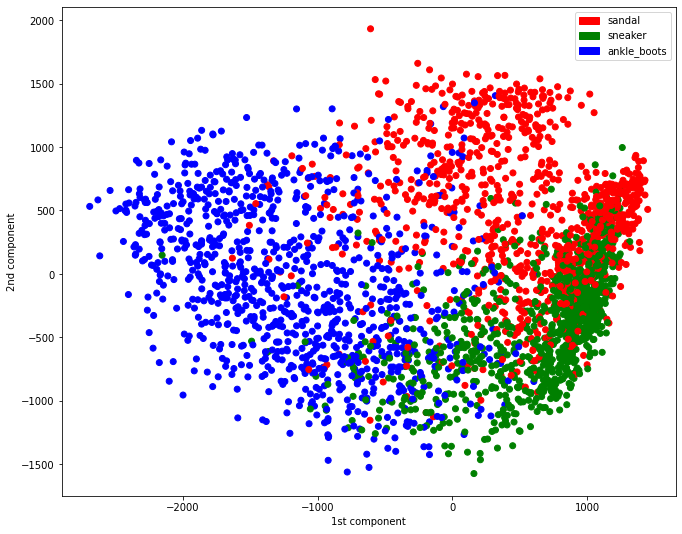

In [40]:
def get_colors(y):
    colors = {
        5: "red",
        7: "green",
        9: "blue"
    }
    return [colors[c] for c in y]


r_patch = mpatches.Patch(color='red', label=labels[5])
g_patch = mpatches.Patch(color='green', label=labels[7])
b_patch = mpatches.Patch(color='blue', label=labels[9])

plt.figure(figsize=(11, 9))
plt.scatter(pca_mtx[:, 0], pca_mtx[:, 1], c=get_colors(y_test))
plt.ylabel("2nd component")
plt.xlabel("1st component")
plt.legend(handles=[r_patch, g_patch, b_patch])
plt.show()